In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import scipy.signal
%config InlineBackend.figure_format='retina'

import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt

In [3]:
reload(hpt)

<module 'helper_finetime' from 'C:\\Users\\mathusla\\Documents\\MATHUSLA\\JupyterNotebooks\\Hardware\\FineTime\\..\\helper_finetime.py'>

In [69]:
def finetime_calib(times, low=None, high=None):
    if low is None:
        times = np.array(times)
        mask = (times > 4)& (times < 1000)
        low = np.min(times[mask])
        high=np.max(times[mask])
        
    total_uncalib = high-low
    finetime_calib = (times-low)/total_uncalib*25
    
    return finetime_calib


def load_finetime_comp(filename, ch ="0", ftime_min=None, ftime_max=None, finetime_roll=0):
    
    if type(ch) is str:
        data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_"+ch, "FINE_"+ch,"RUN_EventTimecode_ns"])
        data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)

        if finetime_roll!=0:
            data[f"FINE_calib_{ch}"]= (data[f"FINE_calib_{ch}"]+finetime_roll)%25    
            
    return data


def load_finetime(filename, chs =["0","1"], ftime_min=None, ftime_max=None, finetime_roll=0):
    
    if type(chs) is list:
        keys_to_read = ['RUN_EventTimeCodeLSB', 'RUN_EventTimecode_ns', 'T0_to_Event_Timecode', 'T0_to_Event_Timecode_ns']
        for ch in chs:
            keys_to_read.append("CHARGE_"+ch)
            keys_to_read.append("FINE_"+ch)
            keys_to_read.append("COARSE_"+ch)
            keys_to_read.append("HIT_"+ch)

        data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=keys_to_read)

        for ch in chs:
            data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
            data[f"TIMESTAMP_{ch}"] = (data["COARSE_"+ch]+1)*25 - data[f"FINE_calib_{ch}"]

        return data
    
    elif type(chs) is str:
        return load_finetime_comp(filename, ch =chs, ftime_min=ftime_min, ftime_max=ftime_max, finetime_roll=finetime_roll)
    

In [71]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\165.data"
# data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip")
data = hpt.load_finetime(filename, chs =["16","17"])

In [77]:
filename = f"{DATA_DIR}\\150.data"
data_bkg = load_finetime(filename, chs =["16","17"])

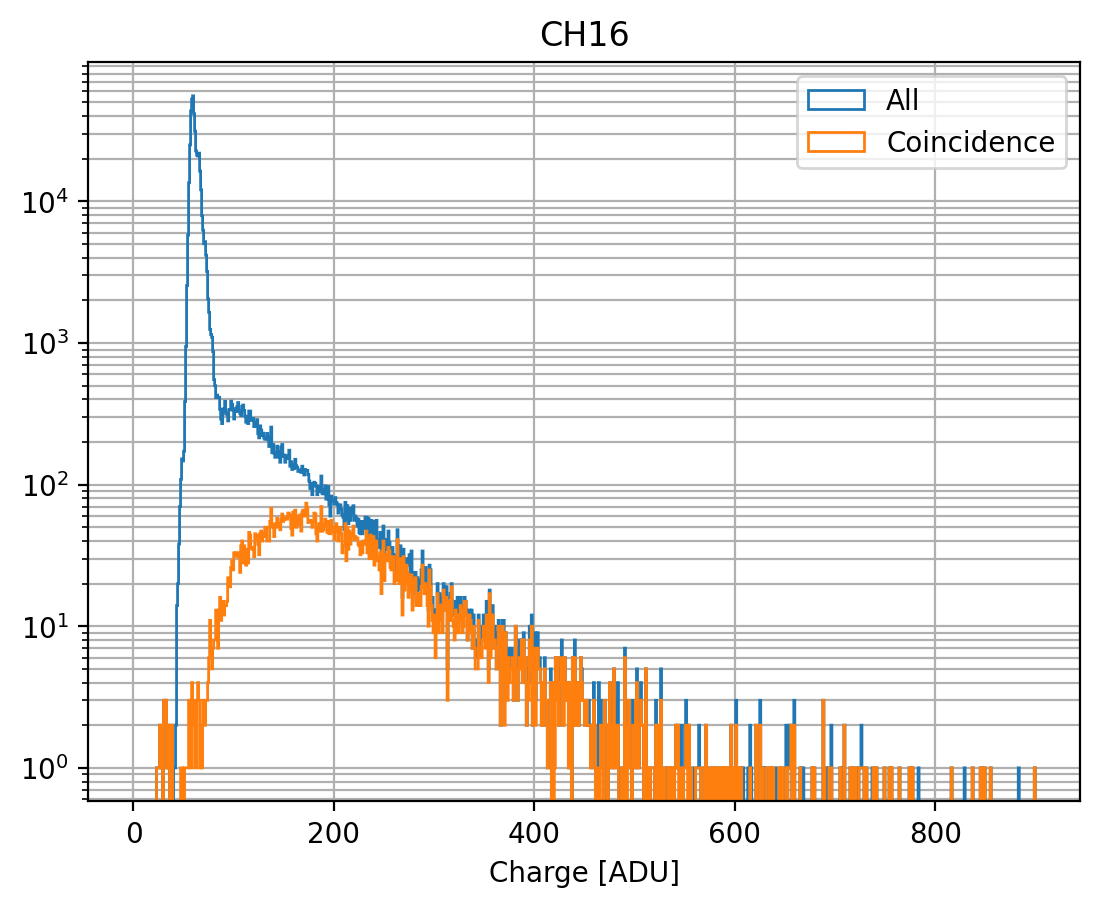

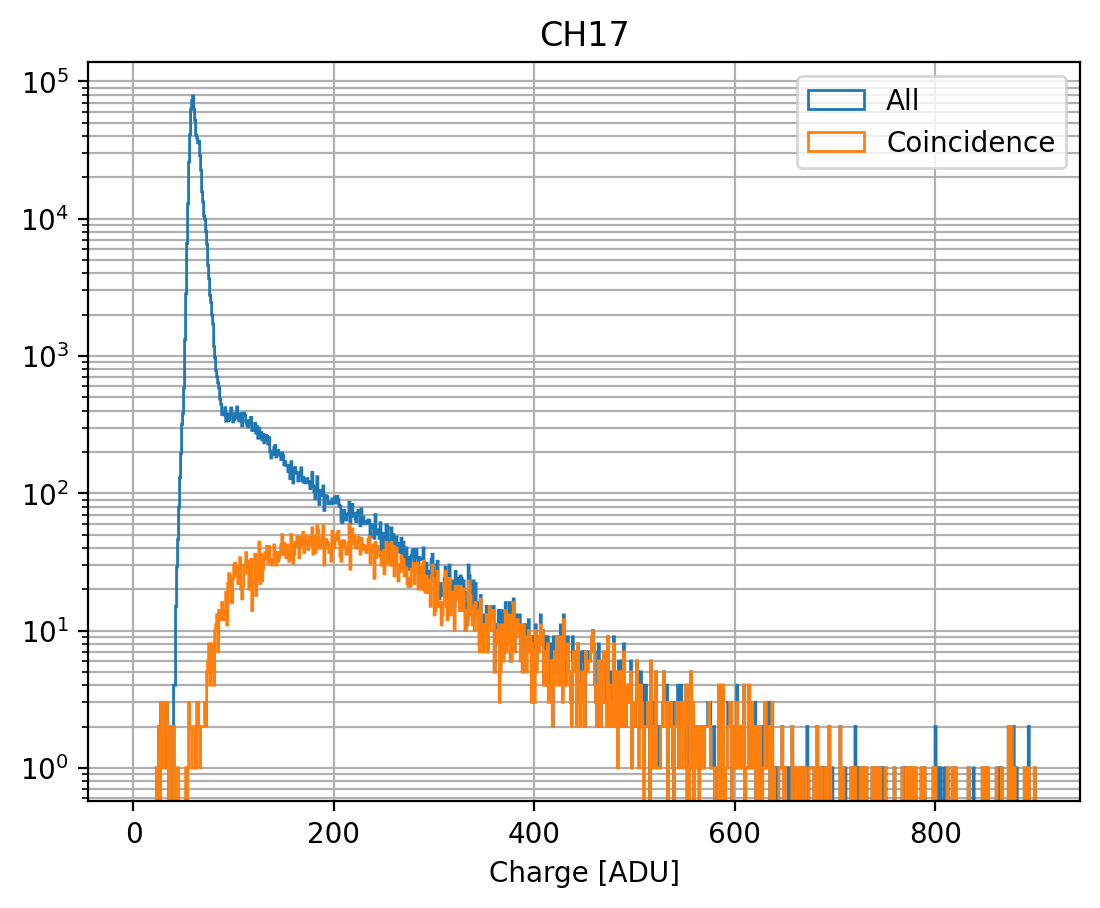

In [72]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17
mask_charge_16 = data["CHARGE_16"]>75
mask_charge_17 = data["CHARGE_17"]>75
mask_charge_16b = data["CHARGE_16"]>90
charge_min = np.min([data["CHARGE_16"],data["CHARGE_17"]],axis=0)



# hist(data["CHARGE_17"],bins=np.linspace(0,200,201),histtype="step");
hist(data["CHARGE_16"][mask_hit16],bins=np.linspace(0,900,901),histtype="step", label="All");
hist(data["CHARGE_16"][mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="Coincidence");

# hist(data_bkg["CHARGE_16"],bins=np.linspace(0,200,201),histtype="step");
# hist(data_bkg["CHARGE_16"][data_bkg["HIT_16"]==1],bins=np.linspace(0,200,201),histtype="step");

yscale("log")
title("CH16")
xlabel("Charge [ADU]")
legend()
grid(which="both")
show()




# hist(data["CHARGE_17"],bins=np.linspace(0,200,201),histtype="step");
hist(data["CHARGE_17"][mask_hit17],bins=np.linspace(0,900,901),histtype="step", label="All");
hist(data["CHARGE_17"][mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="Coincidence");

yscale("log")
title("CH17")
xlabel("Charge [ADU]")
grid(which="both")
legend()
show()



0.8753580668251822


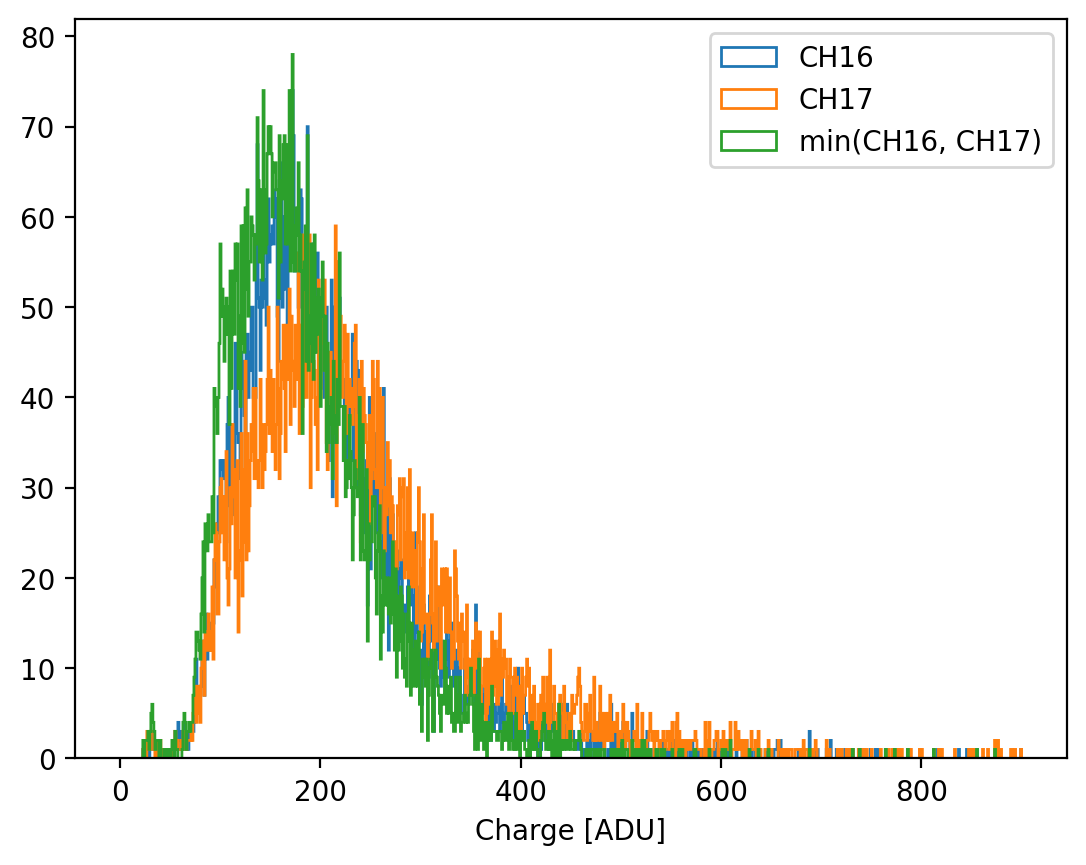

In [73]:
hist((data["CHARGE_16"])[mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="CH17");
hist((charge_min)[mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="min(CH16, CH17)");
legend()
xlabel("Charge [ADU]")
print(1/np.mean((data["CHARGE_17"])[mask_coinc])*np.mean((data["CHARGE_16"])[mask_coinc]))

In [74]:
ch16_charge_avg = np.mean(data["CHARGE_16"][mask_coinc])
ch17_charge_avg = np.mean(data["CHARGE_17"][mask_coinc])
print(ch17_charge_avg/ch16_charge_avg)

1.14238965504354


In [75]:
50*5* 1/60 * 3600

15000.000000000002

In [76]:
sum(data["CHARGE_17"][mask_hit17]>90), sum(mask_coinc)

(30895, 9585)

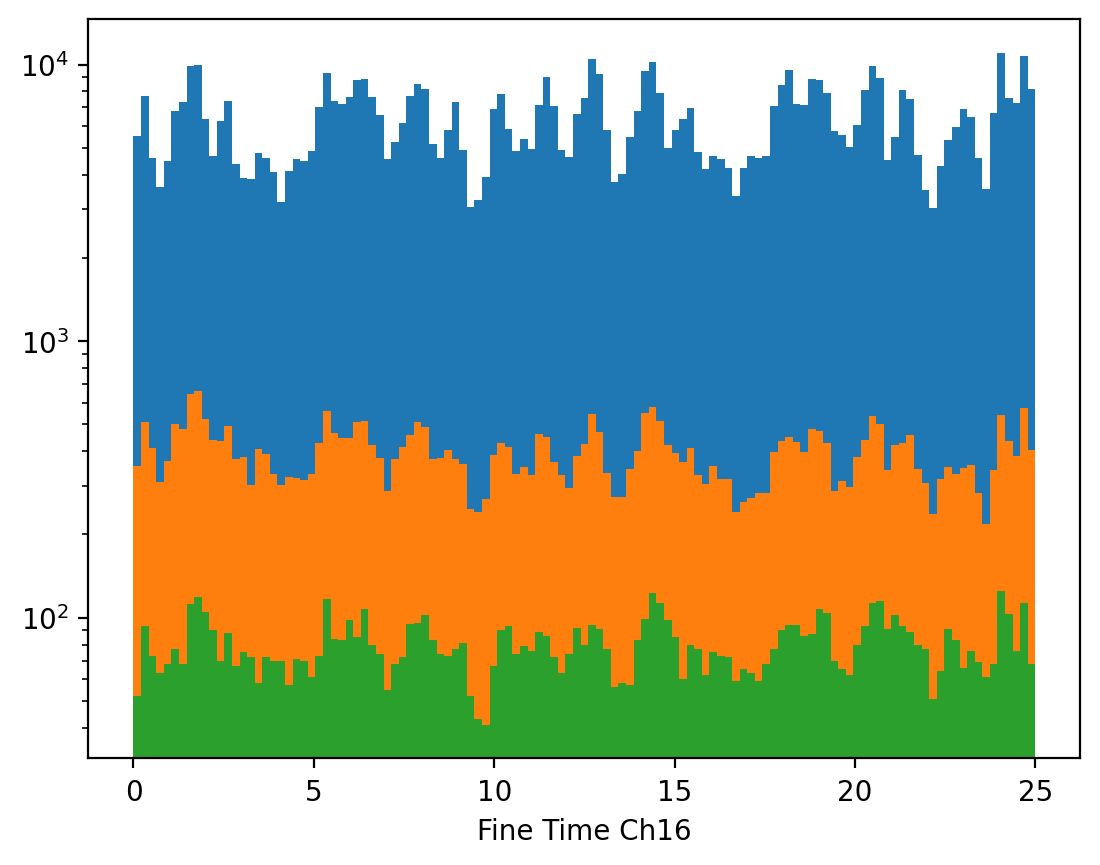

In [77]:
bins=np.linspace(0,25,120)

hist(data.FINE_calib_17, bins=bins)
hist(data.FINE_calib_17[mask_charge_17], bins=bins);
hist(data.FINE_calib_17[mask_charge_17&mask_coinc], bins=bins);
xlabel("Fine Time Ch16")
yscale("log")

In [100]:
reload(hp)

<module 'helper_basic' from 'C:\\Users\\mathusla\\Documents\\MATHUSLA\\JupyterNotebooks\\Hardware\\FineTime\\..\\helper_basic.py'>

Text(0.5, 0, 'dt [ns]')

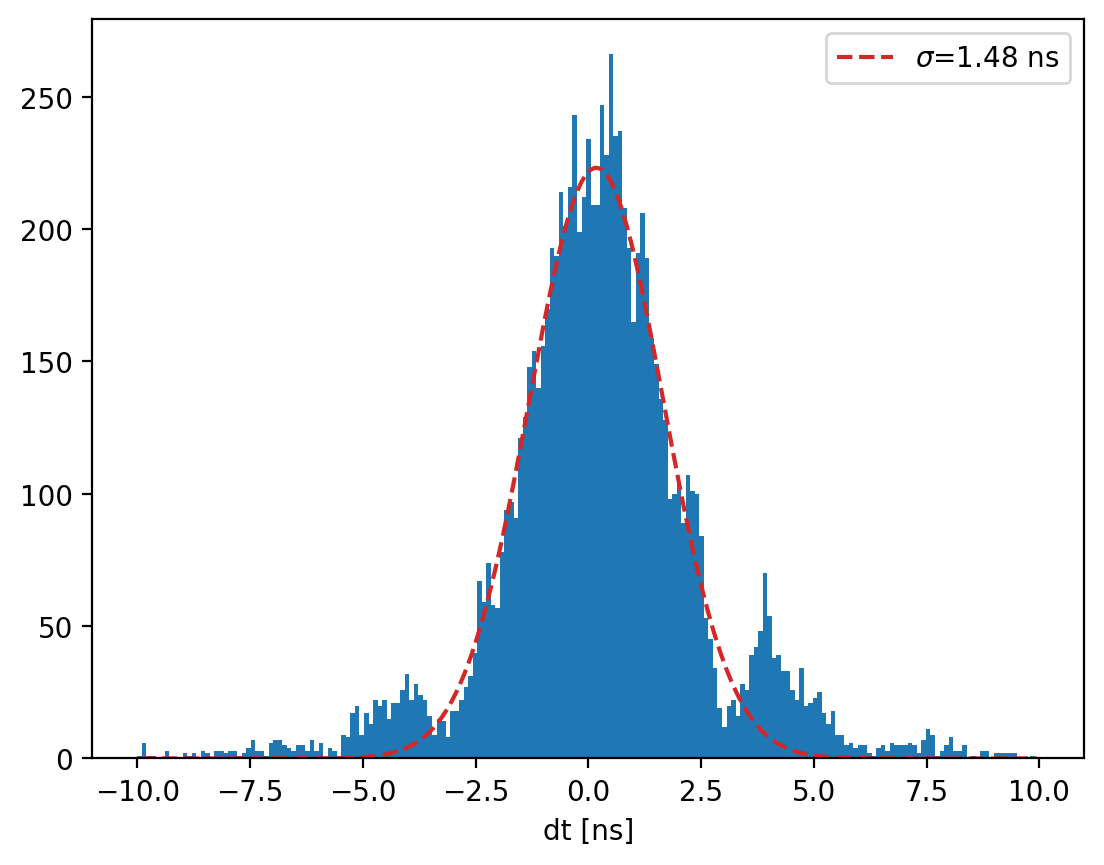

In [103]:
dt = (data.TIMESTAMP_16-data.TIMESTAMP_17)

h=hist(dt[mask_coinc], bins=np.linspace(-10,10,200));
# hist(dt[mask_coinc & (np.abs(charge_min-200)<10)], bins=np.linspace(-10,10,200));
# hist((data.FINE_calib_16-data.FINE_calib_17)[mask_coinc], bins=np.linspace(-20,20,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")

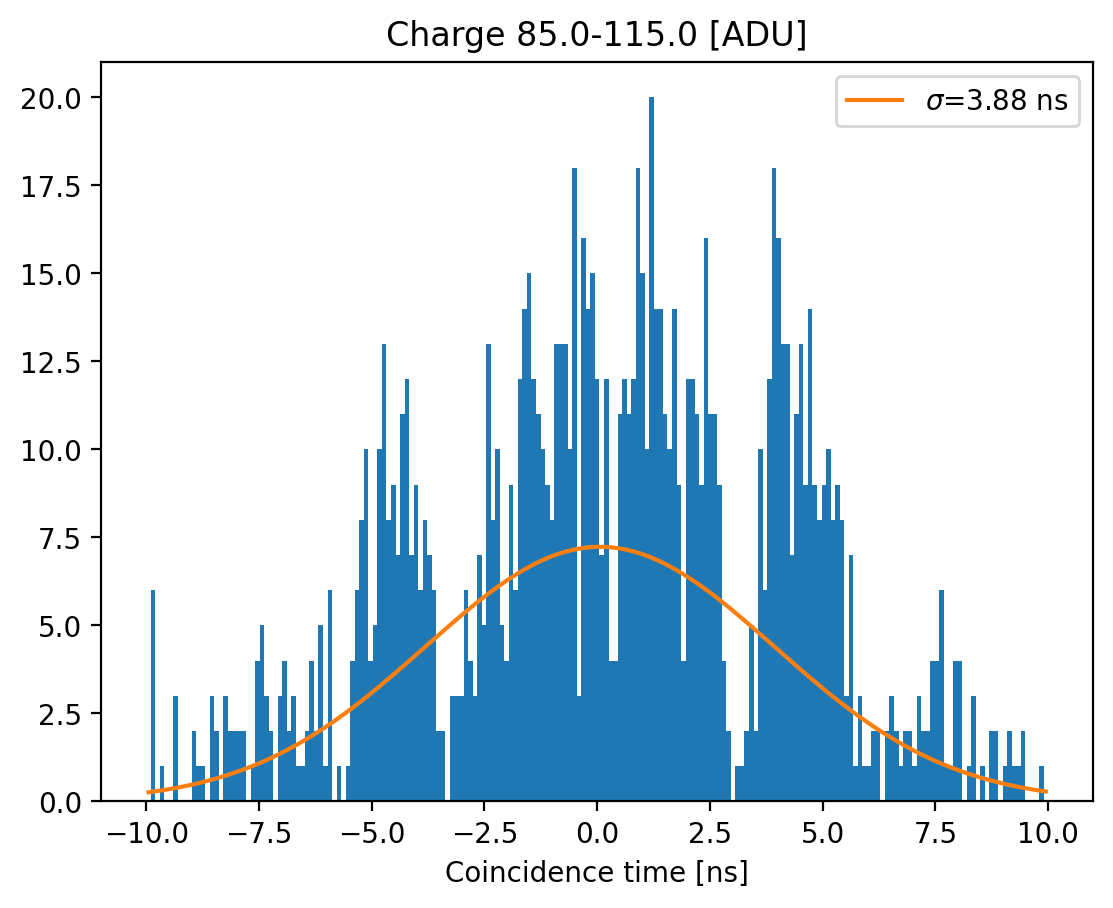

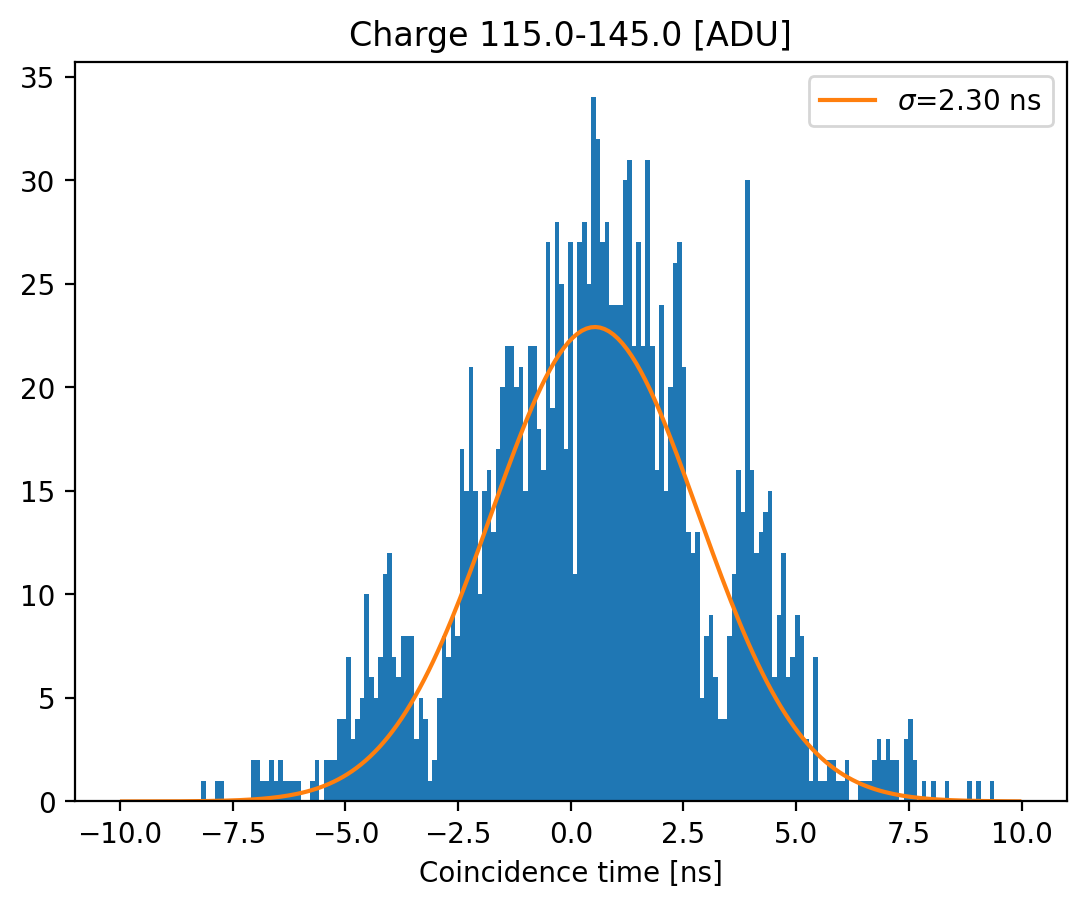

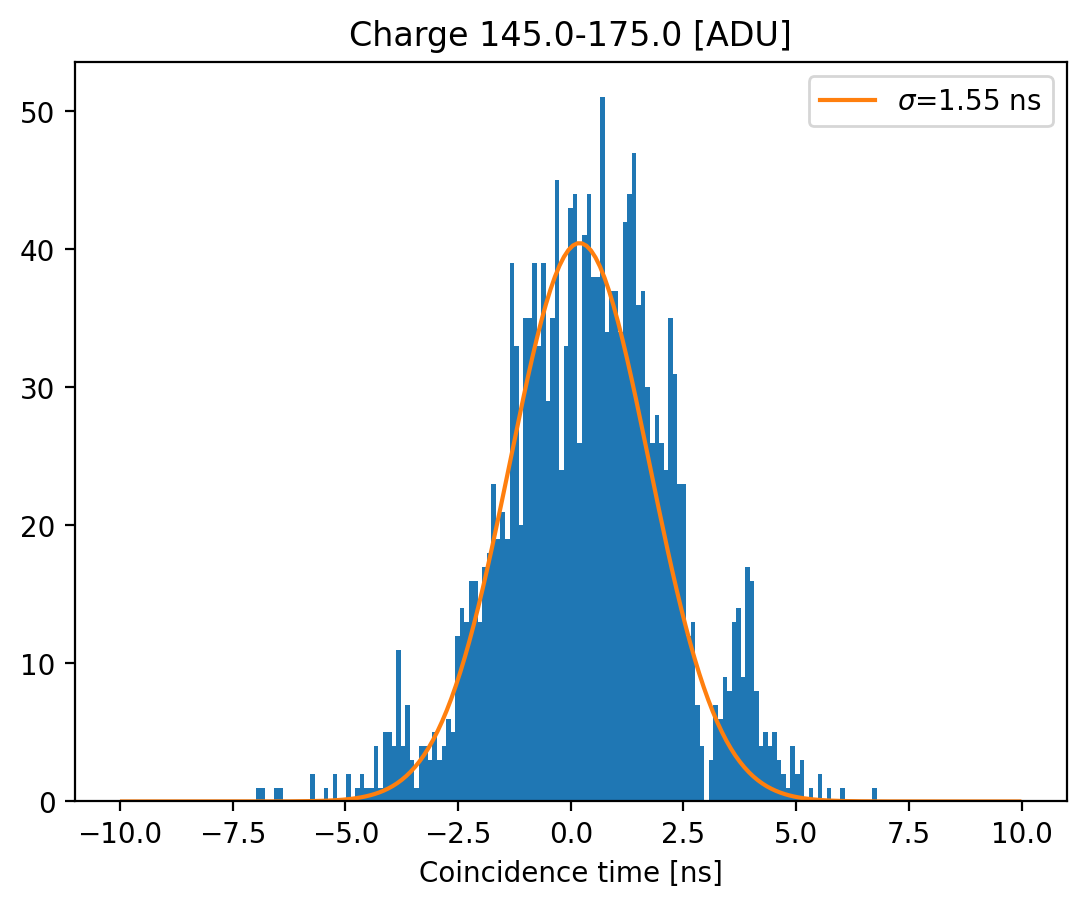

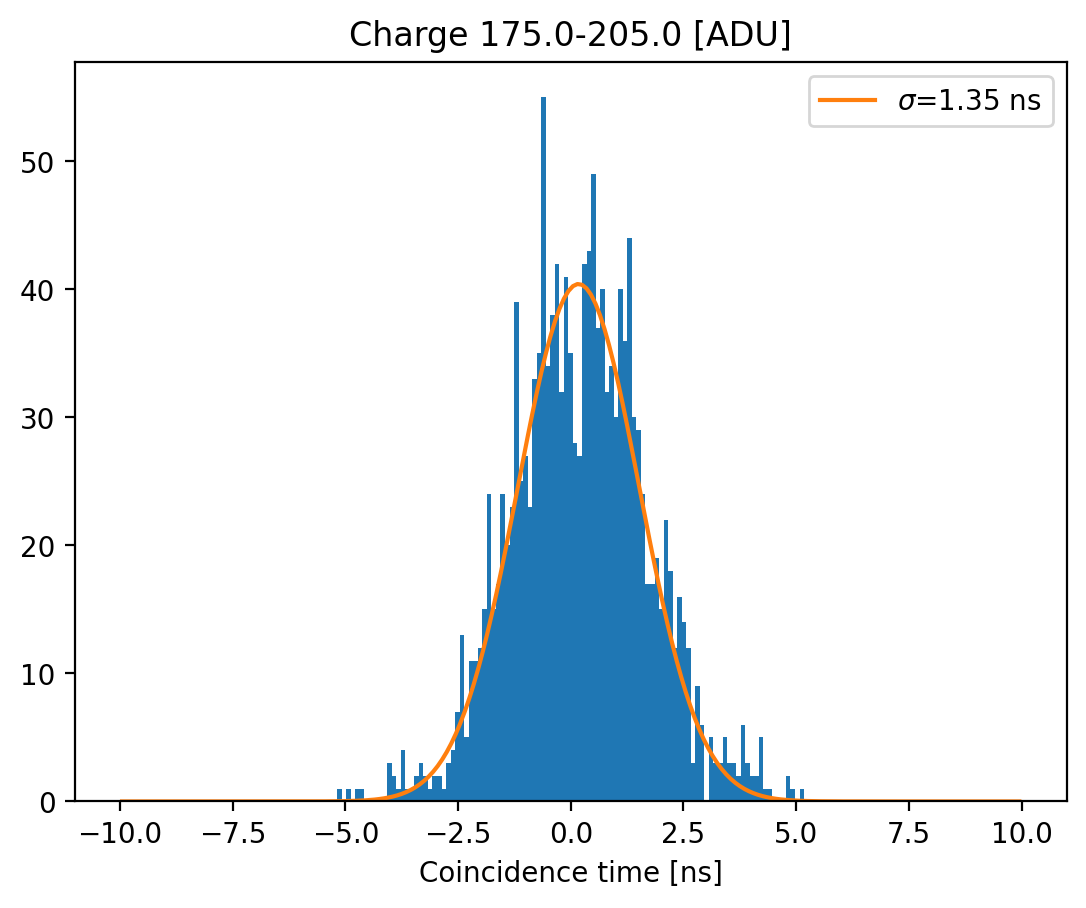

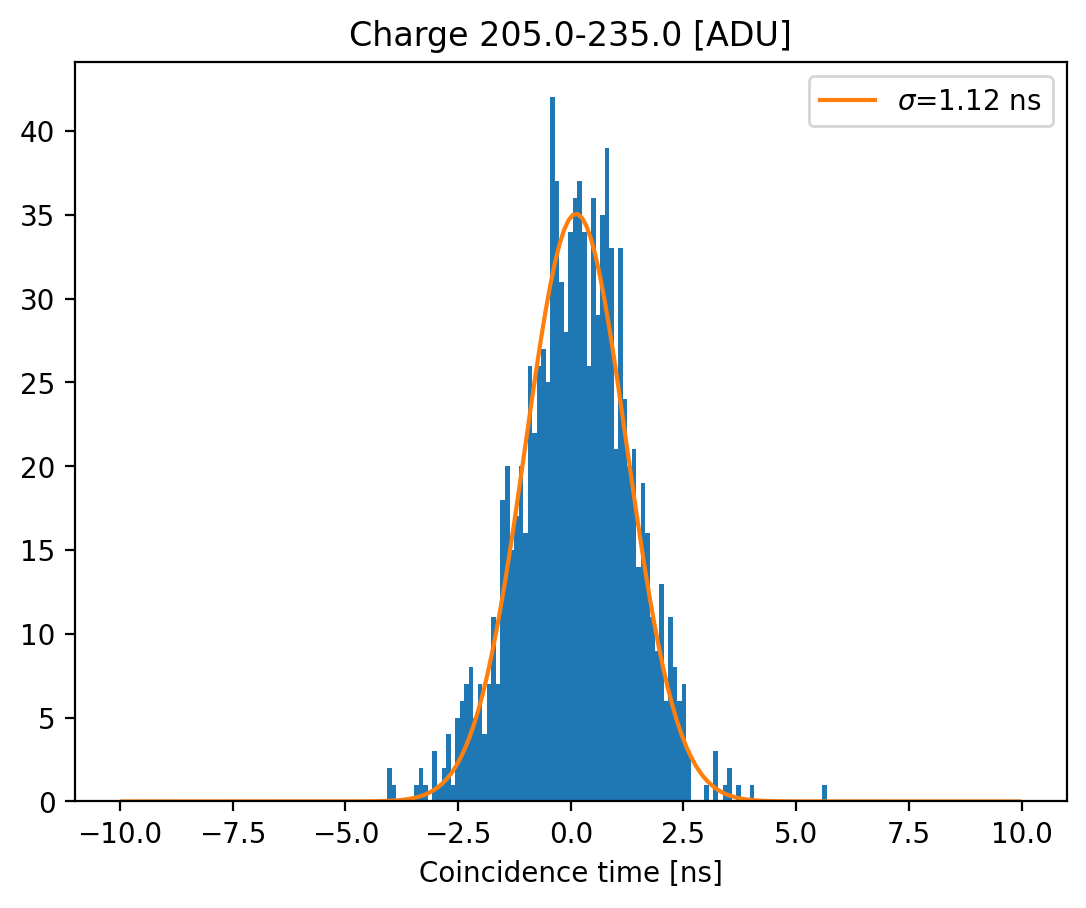

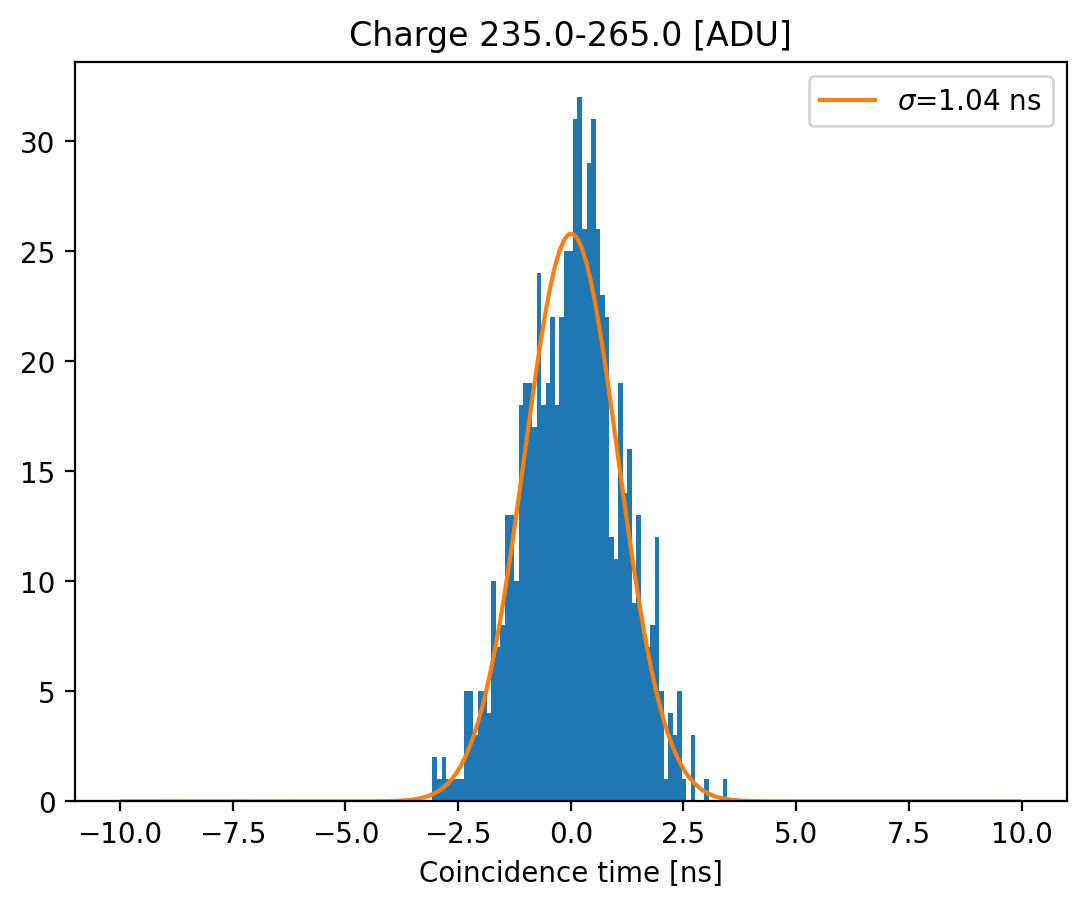

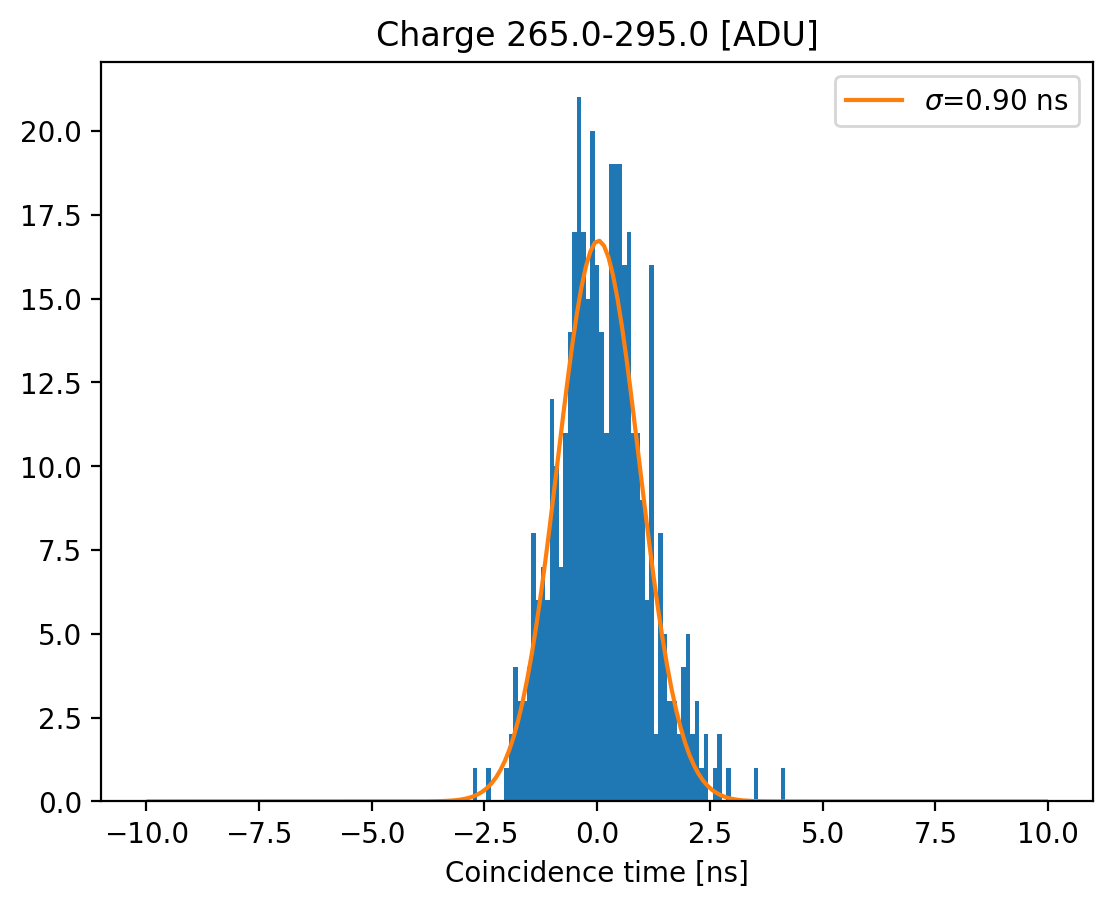

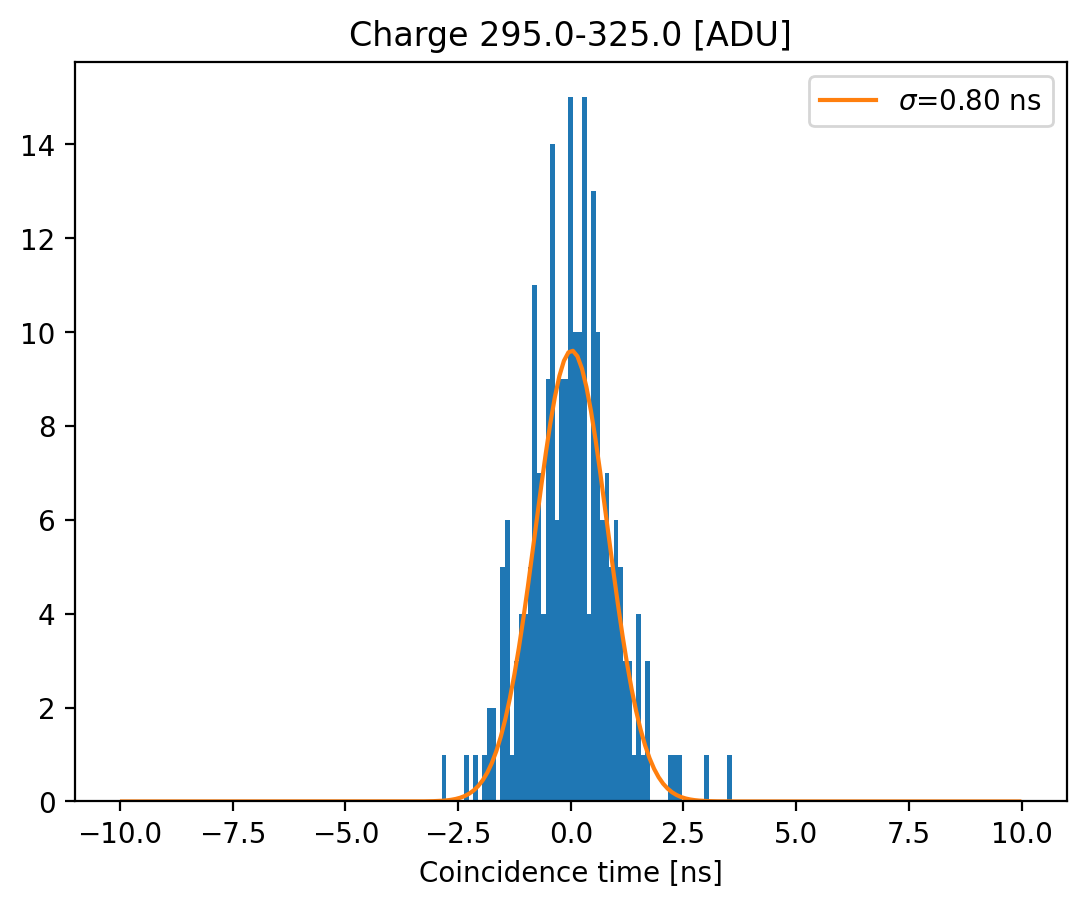

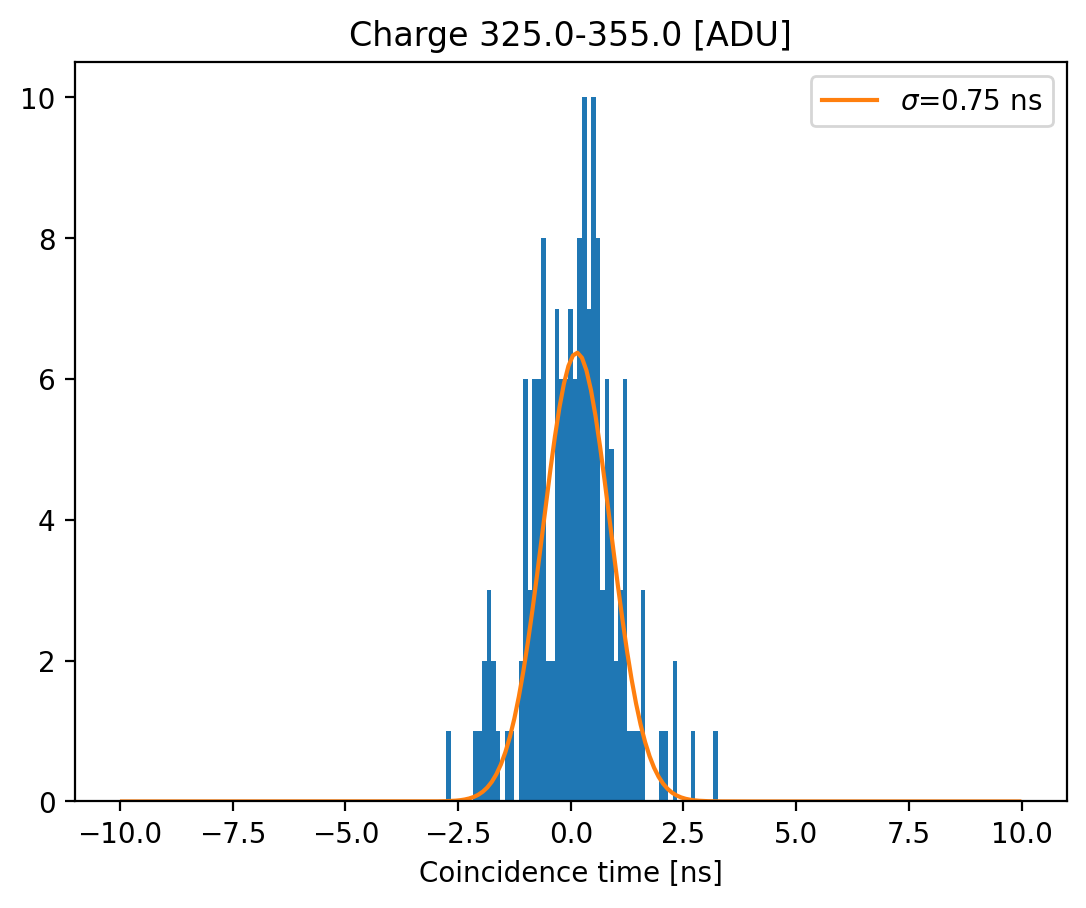

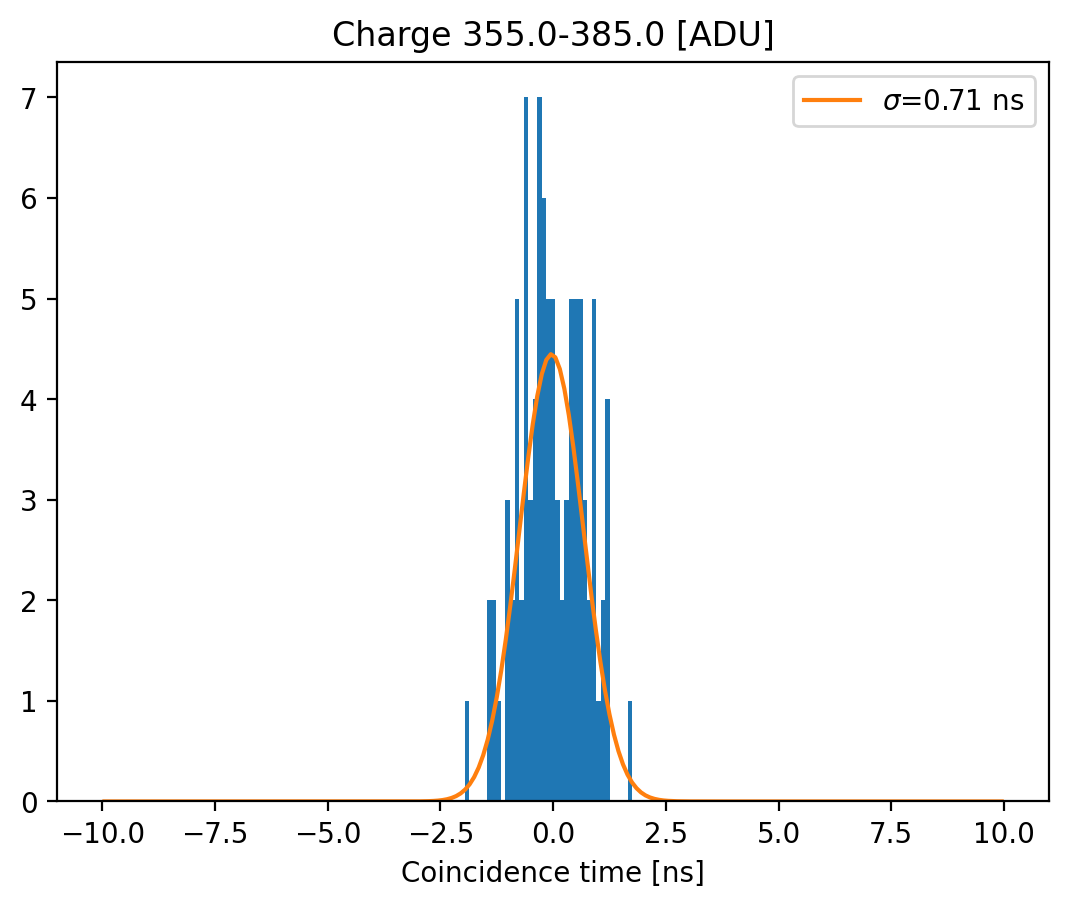

In [111]:
mask = mask_coinc

list_charge=[]
list_sigma = []
for i in range(10):
    gap=30
    mask = mask_coinc  & (np.abs(charge_min-(100+i*gap))<(gap/2))
    h=hist(dt[mask], bins=np.linspace(-10,10,200));
    popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns");
    legend()
    
    avg_charge = np.mean(charge_min[mask])
    list_charge.append(avg_charge)
    list_sigma.append(popt[2])
    title(f"Charge {100+gap*i-gap/2}-{100+gap*i+gap/2} [ADU]")
    xlabel("Coincidence time [ns]")
    show()

[10.63756614 14.91830065 19.23670272 23.62449183 28.04248991 32.39913097
 36.81410935 41.39618406 45.86388889 50.20216049],[2.74331943 1.62409646 1.09336554 0.95373498 0.79384611 0.73599251
 0.63970565 0.56407683 0.53270431 0.50257593]


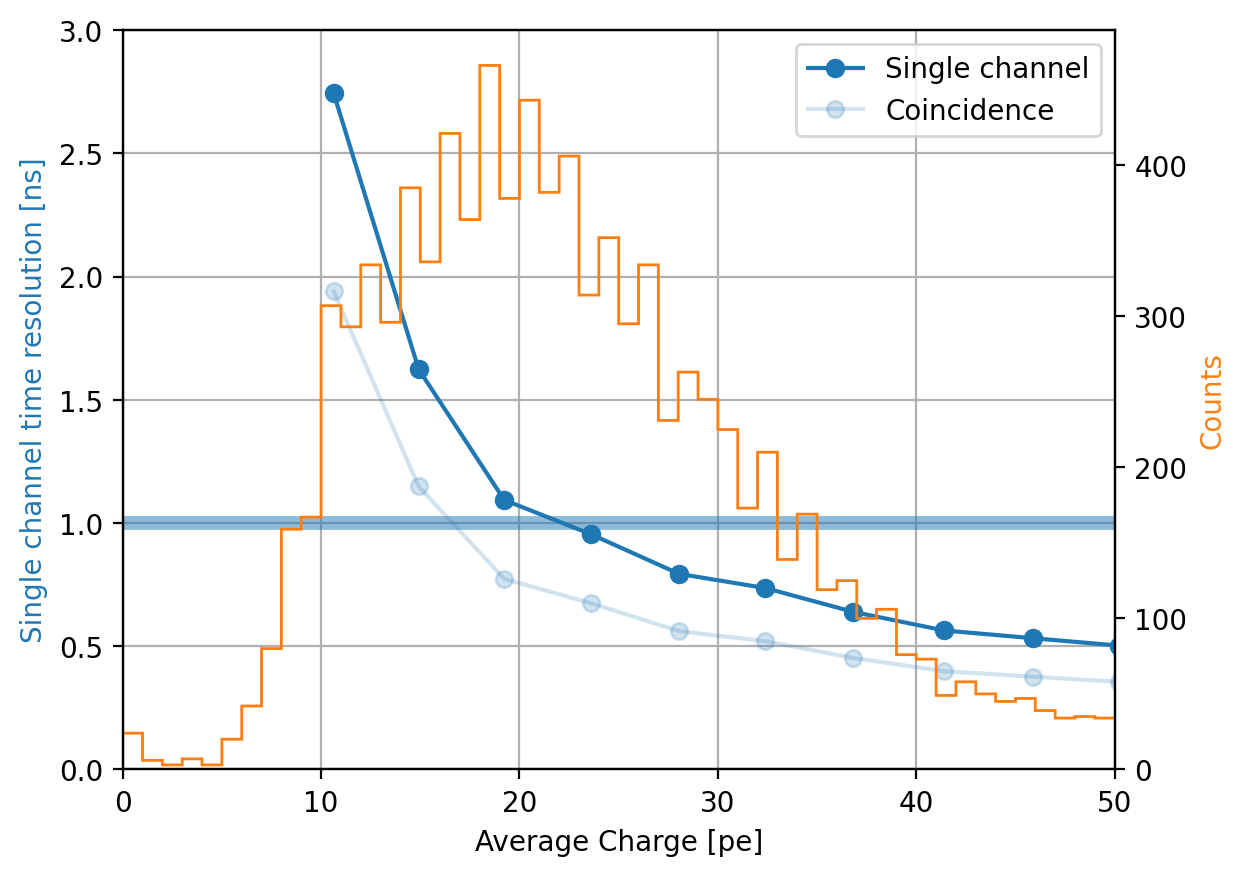

In [126]:
list_charge=np.array(list_charge)
list_sigma=np.array(list_sigma)
plot((list_charge-30)/6.75, list_sigma/np.sqrt(2), marker="o", label="Single channel")
plot((list_charge-30)/6.75, list_sigma/2, marker="o", color="C0", alpha=0.2, label="Coincidence")
xlabel("Average Charge [pe]")
ylabel("Single channel time resolution [ns]")
legend()
grid()
axhline(1, linewidth=5, color="C0", alpha=0.5)
# legend()
xlim(0,50)
ylim(0,3)
gca().yaxis.label.set_color("C0")

gca().twinx()
hist((charge_min[mask_coinc]-30)/6.5,bins=np.linspace(0,900,901),histtype="step", label="min(CH1, CH2)", color="C1");
# legend()
xlabel("Charge [ADU]")
ylabel("Counts")
gca().yaxis.label.set_color("C1")


print((list_charge-30)/6.75, list_sigma/np.sqrt(2), sep=",")

In [129]:
print(*(list_charge-30)/6.75, sep=",")
print(*list_sigma/np.sqrt(2), sep=",")

10.637566137566138,14.91830065359477,19.236702716854975,23.62449183189924,28.042489908646694,32.39913097454997,36.81410934744268,41.39618406285073,45.86388888888889,50.20216049382716
2.743319429739525,1.6240964592967233,1.0933655439605,0.9537349832921947,0.793846111088904,0.7359925131433974,0.6397056522301402,0.5640768276312181,0.5327043052678697,0.5025759310368004


---
# Bars comparison

In [50]:
data1 = load_finetime(f"{DATA_DIR}\\156.data", chs =["16","17"])
data2 = load_finetime(f"{DATA_DIR}\\158.data", chs =["16","17"])
data3 = load_finetime(f"{DATA_DIR}\\159.data", chs =["16","17"])

NameError: name 'load_finetime' is not defined

In [ ]:
hist(data1["CHARGE_17"][data1["HIT_17"]==1],bins=np.linspace(0,900,901),histtype="step", label="1x50 cm, 2 hole");
hist(data2["CHARGE_17"][data2["HIT_17"]==1],bins=np.linspace(0,900,901),histtype="step", label="2x50 cm, 1 hole", weights = np.ones(sum(data2["HIT_17"]==1))*2);
hist(data3["CHARGE_17"][data3["HIT_17"]==1],bins=np.linspace(0,900,901),histtype="step", label="2x50 cm, 2 hole", weights = np.ones(sum(data3["HIT_17"]==1))*2);
# hist(data["CHARGE_16"][data["HIT_16"]==1],bins=np.linspace(0,900,901),histtype="step", label="2x50 cm, 2 hole");
# hist(data1["CHARGE_17"][data1["HIT_17"]==1].values*2.1,bins=np.linspace(0,900,200),histtype="step", label="1x50 cm, 2 hole");


yscale("log")
title("CH16")
xlabel("Charge [ADU]")
legend()
grid(which="both")
axvline(120)
show()

In [ ]:
1/60*50*5 * 3600

In [238]:
sum((data3["HIT_17"]==1)&(data3["CHARGE_17"]>120))*2, sum((data1["HIT_17"]==1)&(data1["CHARGE_17"]>120)), 

(15878, 7671)

In [104]:
reload(hp)

<module 'helper_basic' from 'C:\\Users\\mathusla\\Documents\\MATHUSLA\\JupyterNotebooks\\Hardware\\FineTime\\..\\helper_basic.py'>

In [108]:
x = np.linspace(-20,20,200)
y = hp.Pulse(x, x0 = 8, tau1=2, tau2=20) +np.random.normal(0, 1, len(x))*0.03

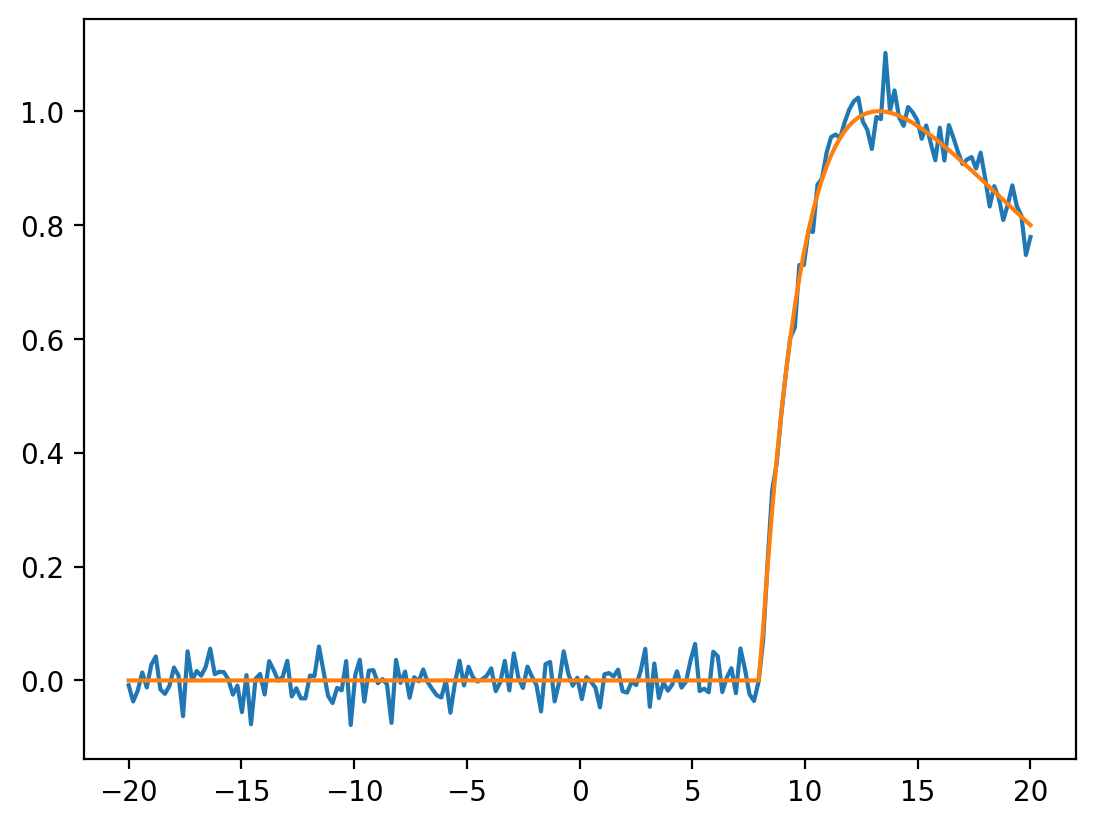

In [109]:
plot(x,y)

popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[x[np.argmax(y)], 1., 10])